In [1]:
from pathlib import Path
from math import floor,log10
import json
from src.data_structures import Instance
from matplotlib import pyplot as plt
import numpy as np
def round_sig(x, sig=2):
    return round(x, sig-int(floor(log10(abs(x))))-1)

In [2]:
#Cargo las instancias, y los resultados desde cada carpeta, y los combino
results_path = Path("final_results")
baldo_data_path = Path("baldo_test_data")
files = results_path.iterdir()
names_to_use = [file.name for file in files]
instances = [] 
for file in names_to_use:
    instance = Instance.from_file(baldo_data_path/file)
    instance.file_name = file
    instances.append(instance)
    result = open(results_path/instance.file_name,"r")
    result_data = json.load(result)
    result.close()
    instance.result = result_data
instances.sort(key=lambda x: x.n_items)

In [3]:
matrix = []
for instance in instances:
    if instance.result["Solver_of"] == -1:
        continue
    if instance.result["BaldoML_of"] == -1:
        continue

    sol_of = instance.result["Solver_of"]
    sol_time = instance.result["Solver_time"] + 1
    gap = lambda instance,x: ((instance.result["Solver_of"]-instance.result[x])/instance.result["Solver_of"])
    points = []
    points.append((gap(instance,f"BaldoGA_of"),(instance.result[f"BaldoGA_time"])/sol_time))
    points.append((gap(instance,f"BaldoML_of"),(instance.result[f"BaldoML_time"])/sol_time))
    for i in range(1,11):
        threshold = round(0.05*i,3)
        points.append((gap(instance,f"Z_threshold{threshold}_of"),(instance.result[f"Z_threshold{threshold}_time"]/sol_time)))
    matrix.append(points)
    


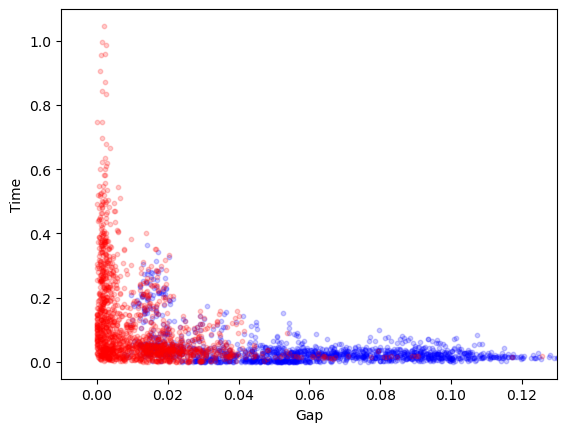

In [4]:
#plt.legend(loc="upper right")
plt.xlabel("Gap")
plt.ylabel("Time")
plt.xlim(-0.01,0.13)


matrix = np.array(matrix)
i = 1
plt.scatter(matrix[:,11,0],matrix[:,11,1],alpha=0.2,color ="blue",s=10)
plt.scatter(matrix[:,2,0], matrix[:,2,1],alpha=0.2,color ="red",s=10)

Text(0.5, 0, '$\tau$')

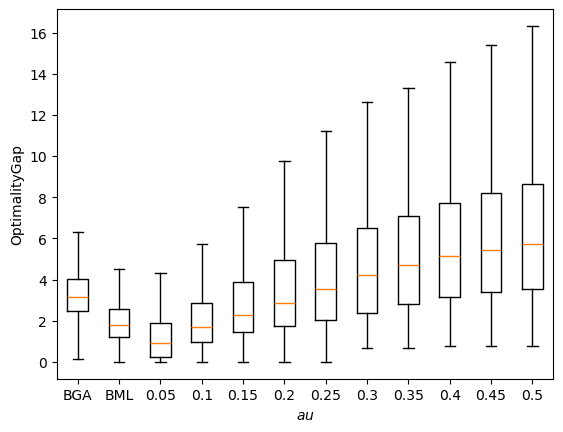

In [5]:
#Boxplot del Gap con distintos Tau y otros metodos
#matrix[instance,solver,gap]
bplot = plt.boxplot(matrix[:,:,0]*100,showfliers=False)
plt.xticks([i for i in range(1,13)],["BGA","BML"]+[str(round(i*0.05,3)) for i in range(1,11)])
plt.ylabel("OptimalityGap")
plt.rc("text",usetex=True)
plt.xlabel('$\tau$')


In [6]:
#Boxplot del Gap con distintos Tau y otros metodos

print(np.average(matrix[1,:,0]))




0.06321600685638155


{'whiskers': [<matplotlib.lines.Line2D object at 0x7f187adae690>, <matplotlib.lines.Line2D object at 0x7f187adbb1d0>, <matplotlib.lines.Line2D object at 0x7f187adc6910>, <matplotlib.lines.Line2D object at 0x7f187adc7110>, <matplotlib.lines.Line2D object at 0x7f187add66d0>, <matplotlib.lines.Line2D object at 0x7f187add6ed0>, <matplotlib.lines.Line2D object at 0x7f187ade23d0>, <matplotlib.lines.Line2D object at 0x7f187ade2cd0>, <matplotlib.lines.Line2D object at 0x7f187adf5f10>, <matplotlib.lines.Line2D object at 0x7f187adf67d0>, <matplotlib.lines.Line2D object at 0x7f187ae05bd0>, <matplotlib.lines.Line2D object at 0x7f187ae06390>, <matplotlib.lines.Line2D object at 0x7f187ae11990>, <matplotlib.lines.Line2D object at 0x7f187ae12250>, <matplotlib.lines.Line2D object at 0x7f187ae1d510>, <matplotlib.lines.Line2D object at 0x7f187ae1ddd0>, <matplotlib.lines.Line2D object at 0x7f187ae2d0d0>, <matplotlib.lines.Line2D object at 0x7f187ae2d8d0>, <matplotlib.lines.Line2D object at 0x7f187ae38cd0>

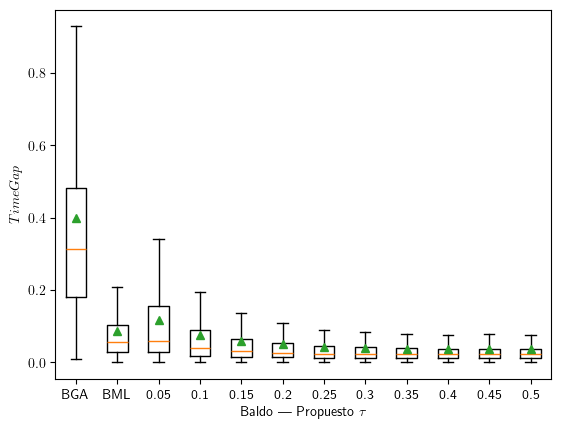

In [7]:
#Boxplot del TimeGap con distintos tau
#matrix[instance,solver,gap]
bplot = plt.boxplot(matrix[:,:,1],showmeans=True,showfliers=False)
plt.xticks([i for i in range(1,13)],["BGA","BML"]+[str(round(i*0.05,3)) for i in range(1,11)])
plt.ylabel(r"$TimeGap$")
plt.xlabel(r'Baldo | Propuesto $\tau$')
plt.savefig("assets/full_timegap_comparison.png")
print(bplot)


In [8]:
from itertools import groupby

def by_size_performance(metodo: str,plot=True):
    by_size_instances = groupby(instances,key=lambda ins: ins.n_items)
    sizes = []
    keys  = []
    for key, group in by_size_instances:
        points = []
        keys.append(key)
        for instance in group:
            if instance.result["Solver_of"] == -1:
                continue
            sol_of = instance.result["Solver_of"]
            sol_time = instance.result["Solver_time"] + 1
            gap = lambda instance,x: ((instance.result["Solver_of"]-instance.result[x])/instance.result["Solver_of"])
            points.append((gap(instance,f"{metodo}_of"),(instance.result[f"{metodo}_time"]/sol_time)))
        sizes.append(np.array(points))
    data_to_plot = [points[:,0] for points in sizes]
    if plot:
        boxplot = plt.boxplot(data_to_plot,showfliers=False)
    return sizes



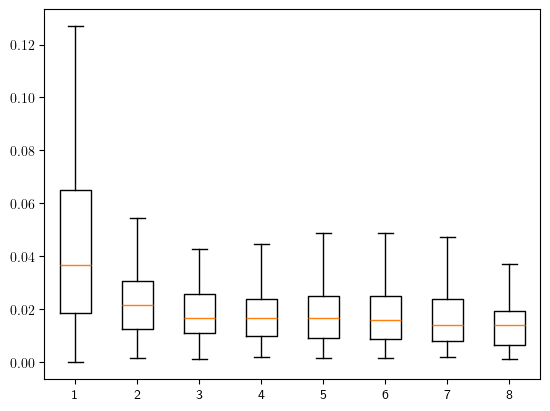

In [9]:
sizes = by_size_performance(f"Z_threshold0.1")



In [10]:
#Listas de gaps

gap_type = 1 #1 es time 0 es optimality gap
metodo = "BaldoML"
types = ["Gap","Time"]
print(metodo,types[gap_type])
for i in range(8):
    points = by_size_performance(metodo,plot = False)[i][:,gap_type]
    name = f"{100 +200*i }: "
    mean = np.average(points)
    if gap_type == 0:
        mean = mean*100
    mean = round_sig(mean,3)
    if mean < 0.001:
        mean = "{:.3e}".format(mean)
    std =  np.std(points)

    if gap_type == 0:
        std = std * 100
    std = round_sig(std,3)
    if std < 0.01:
        std = "{:.3e}".format(std)

    print(name+ f"Mean: {mean} Std: {std}")
    
    

BaldoML Time
100: Mean: 0.0569 Std: 0.0135
300: Mean: 0.0431 Std: 0.0238
500: Mean: 0.0353 Std: 0.0276
700: Mean: 0.0358 Std: 0.0323
900: Mean: 0.0318 Std: 0.0339
1100: Mean: 0.165 Std: 0.11
1300: Mean: 0.156 Std: 0.105
1500: Mean: 0.162 Std: 0.123


In [11]:
#Listas de gaps

gap_type = 1 #1 es time 0 es optimality gap
metodo = "Z_threshold0.25"
types = ["Gap","Time"]
print(metodo,types[gap_type])
for i in range(8):
    points = by_size_performance(metodo,plot = False)[i][:,gap_type]
    name = f"{100 +200*i }: "
    mean = np.average(points)
    if gap_type == 0:
        mean = mean*100
    mean = round_sig(mean,3)
    if mean < 0.001:
        mean = "{:.3e}".format(mean)
    std =  np.std(points)

    if gap_type == 0:
        std = std * 100
    std = round_sig(std,3)
    if std < 0.01:
        std = "{:.3e}".format(std)

    print(name+ f"Mean: {mean} Std: {std}")

Z_threshold0.25 Time
100: Mean: 0.0175 Std: 9.750e-03
300: Mean: 0.0192 Std: 0.0115
500: Mean: 0.0216 Std: 0.016
700: Mean: 0.0229 Std: 0.0204
900: Mean: 0.0207 Std: 0.0216
1100: Mean: 0.0892 Std: 0.0717
1300: Mean: 0.0782 Std: 0.0689
1500: Mean: 0.0754 Std: 0.0767
